# 09 - 不依从性与局部平均处理效应

## 初探异质性世界

此前，我们以更为传统的视角审视了工具变量（IV）。它被视为一种可利用的自然实验。而现代工具变量实践则大量借鉴了医学科学的洞见，根据个体对工具变量的响应方式，将世界划分为四种类型的受试者。

1. 依从者
2. 永不接受者
3. 总是接受者
4. 违抗者

这一命名源自药物科学。设想你正在进行一项实验，测试某种新药对某种疾病的效果。每位受试者被分配到一种治疗方式：药物或安慰剂。依从者是指那些严格遵循分配方案的受试者——若分配到安慰剂则服用安慰剂，若分配到药物则服用药物。永不接受者则是那些拒绝服用药物的受试者，即使被分配了新药也拒不服用。而总是接受者则能通过某种方式获取新药，即便他们被分配的是安慰剂。最后，违抗者是指那些被分配到对照组却接受治疗、被分配到治疗组却选择对照的人，可以将其想象成总是与指令对着干的顽童。实际上，这类情况（指违抗者，而非孩童）并不常见，因此我们通常会忽略他们。

![img](./images/09/defiers.png)

现代工具变量法将工具视为准实验设计，其中依从性并不完美。通过这种方式，它区分了内部有效与外部有效的因果效应。提醒一下，内部有效效应是我们能够识别的效应，在特定数据和环境下是有效的。在工具变量法中，这指的是那些因工具而改变处理的个体的处理效应。另一方面，外部有效性关注的是该因果效应的预测能力，即我们能否将从样本中发现的效应推广到其他群体。例如，假设你在大学里进行了一项随机对照试验，以探究人们在有捐赠激励时是否慷慨。实验设计良好，但仅邀请经济学学生参与。结果发现他们全是自私的家伙。这是内部有效的结论，对那组数据点有效。但你能从该实验推断出人类本性自私吗？这几乎不可能。因此，我们会质疑你的实验是否具备将其结果推广的外部有效性。言归正传，回到工具变量法。

为了更具体地说明，让我们考虑一个你想通过应用内购买提升用户参与度的案例。实现这一目标的一种方法，是要求你的市场营销部门设计一条推送消息来吸引用户。他们提出了一个绝妙的设计和非常精致的用户互动方案。基于这条推送，你着手设计一项随机试验。你随机选取了 10000 名客户，并给每个人分配了 50%的概率接收这条推送。然而，在执行测试时，你注意到一些被分配接收推送的客户实际上并未收到。当你与工程师沟通时，他们解释说，这可能是因为这些客户使用的是较旧的手机，不支持营销团队设计的那种推送功能。

起初，你可能认为这没什么大不了的。你可以直接使用实际接收到的处理作为处理变量，而不是使用分配的处理，对吧？但事实证明事情并不那么简单。如果你绘制整个情况的因果图，它看起来会像这样：

In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")

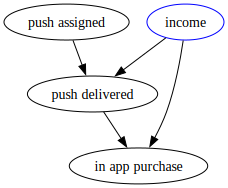

In [27]:
g = gr.Digraph()

g.edge("push assigned", "push delivered")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

在因果图的上游，是推送分配环节。这一设计本身具有随机性，因此不存在任何前因影响。接着，有一个节点表示推送是否成功送达。并非所有被分配接收推送的用户都能实际收到，此处存在不依从情况。更具体地说，存在"永不接受者"：即使被分配接受干预也始终未获处理的人群。且有理由认为这种不依从并非偶然——由于使用老旧手机的用户往往无法接收推送，可以论证收入水平也影响着推送送达率。用户越富裕，拥有高性能手机的可能性越高，进而接收推送的概率也越大。最后是结果变量，即应用内购买行为。需注意我们无法观测收入数据，故无法对其进行控制。基于此背景，让我们分别考察以下两种处理方式的影响：以推送分配作为处理变量，与以实际推送送达作为处理变量。

第一种情况下，我们将通过以下均值差来估计因果效应：

$
ATE = E[Y | pushAssigned=1] - E[Y | pushAssigned=0]
$

正如我们目前所深刻认识到的，只有当偏误 $E[Y_1] - E[Y_0]$ 为零时，这才是对 $E[Y_0|pushAssigned=0] - E[Y_0|pushAssigned=1]$ 的无偏估计。由于 `pushAssigned` 是随机的，我们知道偏误为零。那么问题就此解决了吗？并非完全如此。要知道，如果我们这样做，实际上是在回答一个与我们初衷不同的问题。我们将找到的是**处理分配而非处理本身的因果效应**。但它们是否不同，或者我们能否将处理分配的因果效应外推至平均处理效应（ATE）？换言之，处理分配的因果效应是否是对 ATE 的无偏估计？

事实证明，并非如此。由于不依从性，被分配到处理组的个体的结果会向对照组的结果方向偏移。不依从性无意中反转了处理，使得处理组和对照组在结果上更为相似。请不要将此与变量上的相似性混淆。我们希望处理组和对照组在变量上相似，这将使它们具有可比性。我们不希望的是，如果确实存在处理效果，它们在结果上却表现相似。

要理解这一点，首先假设我们有总是接受者。其中一些人会随机被分配到对照组。但即便如此，他们仍会接受处理。这使得他们本质上成为与对照组混杂的处理群体。由于这种混杂，当我们遇到不依从情况时，因果效应将更难被发现。

![img](./images/09/always_takers.png)

同理，永不接受者会使那些被分配到处理组的人看起来有点像未接受处理的人，因为他们即使被分配到处理组也不会接受处理。从这个意义上说，处理分配的因果效应偏向于零，因为不依从性缩小了可检测到的影响。另一种理解方式是设想一个极端情况。假设不依从性非常高。处理分配与处理接受无关。在这种情况下，处理接受完全是随机的。用工具变量的术语来说，这意味着我们有一个非常弱的第一阶段。用 Z 表示处理分配，我们将得到

$
E[Y|Z=1] - E[Y|Z=0] = 0
$

处理分配与结果之间将不再存在因果联系。Z 将只是一个毫无意义的随机变量漂浮在那里。 

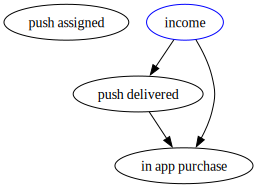

In [30]:
g = gr.Digraph()

g.node("push assigned")
g.edge("push delivered", "in app purchase")
g.edge("income", "in app purchase")
g.edge("income", "push delivered")
g.node("income", color="blue")
g

好吧，我们已经排除了使用分配的因果效应来估计处理的因果效应。那么，直接使用实际接受的处理来做估计怎么样？

$
\mathrm{ATE} = E[Y | \mathrm{push}=1] - E[Y | \mathrm{push}=0]
$

再次，我们需要思考这是否存在偏误，或者是否 $E[Y_0|\mathrm{push}=0] = E[Y_0|\mathrm{push}=1]$。仅通过观察上方的因果图，我们就知道情况并非如此。那个未测量的混杂因素——收入，潜伏在周围，肯定会把事情搞砸。正如我们之前所说，推送失败在我们的案例中是由客户使用旧手机引起的。这意味着我们很可能 $E[Y_0|\mathrm{push}=0] < E[Y_0|\mathrm{push}=1]$。我们认为情况如此，因为资金较少的客户既拥有更旧的手机，这将导致 $\mathrm{push}=0$ ，同时也降低了应用内购买的可能性 $Y_0$。

真糟糕！我们既不能用分配的处理，也不能用实际接受的处理来估计我们的平均处理效应（ATE）。但幸运的是，我们知道可以用什么：工具变量。在这里，分配的处理就是一个完美的工具变量。它几乎是随机的，并且只通过实际处理才会影响应用内购买。

## 局部平均处理效应（LATE）

局部平均处理效应明确指出了我们能够估计因果效应的群体。这也是理解工具变量（IV）的另一种方式，为我们提供了更多可用的直观见解。在现代工具变量理论中，我们将工具变量视为启动一条因果链：Z 导致 T，T 进而导致 Y。在此背景下，排他性约束意味着 Z 不会直接影响 Y，除非通过其对 T 的作用。第一阶段现在被视为 Z 对 T 的因果效应。我们还采用双重索引符号重写潜在结果，其中第一个索引表示工具变量的反事实情况，第二个索引则表示处理的反事实情况。

$
\text{Potential Outcome}=\begin{cases}
Y_i(1, 1) \ \text{if } T_i=1, \ Z_i=1\\
Y_i(1, 0) \ \text{if } T_i=1, \ Z_i=0\\
Y_i(0, 1) \ \text{if } T_i=0, \ Z_i=1\\
Y_i(0, 0) \ \text{if } T_i=0, \ Z_i=0\\
\end{cases}
$

从某种意义上说，在第一阶段中，处理变量变成了结果变量。这意味着我们也可以用潜在结果符号来表示它：

$
\text{Potential Treatment}=\begin{cases}
T_0 \ \text{if } Z_i=0 \\
T_1 \ \text{if } Z_i=1
\end{cases}
$

![img](./images/09/double_index.png)

工具变量假设现在可以重写如下：

1. $T_{0i}, T_{1i} \perp Z_i $ 和 $Y_i(T_{1i},1), Y_i(T_{0i},0) \perp Z_i $。这是独立性假设。它表明工具变量如同随机分配一般有效。换句话说，工具变量 Z 与潜在处理无关，这意味着不同工具变量组的人群具有可比性。

2. $Y_i(1, 0)=Y_i(1, 1)=Y_{i1}$ 和 $Y_i(0, 0)=Y_i(0, 1)=Y_{i0}$。这是排他性约束。它指出，若考察接受处理者的潜在结果，两个工具变量组的结果是相同的。换言之，工具变量不影响潜在结果，即工具变量仅通过处理影响最终结果。

3. $E[T_{1i}-T_{0i}] \neq 0$。这表示第一阶段的存在性。其含义是，第一阶段的潜在结果（即潜在处理）并不相同。换言之，工具变量确实对处理产生了影响。

4. $T_{i1} > T_{i0}$。这是单调性假设。其含义是，若对所有人启用工具变量，其处理水平将高于对所有人群禁用该工具变量时的处理水平。 

现在，让我们回顾一下沃尔德估计量，以进一步理解工具变量（IV）的直观含义：

$
ATE = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

首先，我们来看其中的第一部分，$E[Y|Z=1]$。利用排除限制条件，我们可以将 Y 用潜在结果的形式重写如下。

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})|Z=1]
$

基于独立性假设，我们可以移除对 Z 的条件限制。

$
E[Y_i|Z_i=1]=E[Y_{i0} + T_{i1}(Y_{i1} - Y_{i0})]
$

通过类似的论证，我们得出

$
E[Y_i|Z_i=0]=E[Y_{i0} + T_{i0}(Y_{i1} - Y_{i0})]
$

我们现在可以将沃尔德估计量的分子部分重写如下

$
E[Y|Z=1]-E[Y|Z=0] = E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})]
$

利用单调性，我们可知 $T_{i1}-T_{i0}$ 为 0 或 1，因此

$
E[(Y_{i1}-Y_{i0})(T_{i1}-T_{i0})] = E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})
$

采用类似方法处理分母部分，我们得到

$
E[T|Z=1]-E[T|Z=0]=E[T_{i1}-T_{i0}]=P(T_{i1}>T_{i0})
$

综上所述，我们可以这样理解沃尔德估计量：

$
ATE = \dfrac{E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]P(T_{i1}>T_{i0})}{P(T_{i1}>T_{i0})}=E[(Y_{i1}-Y_{i0})|T_{i1}>T_{i0}]
$

也就是说，通过工具变量（IV）估计的平均处理效应（ATE）是在子群体 $T_{i1}>T_{i0}$ 上的 ATE。若从依从性角度考虑，这一子群体指代的是哪些人？这是指那些在工具开启时接受处理水平高于工具关闭时的群体。换言之，即依从者群体。为了便于记忆，

1. 依从者意味着 $T_{i1}>T_{i0}$
2. 永不接受者 $T_{i1}=T_{i0}=0$
3. 总是接受者 $T_{i1}=T_{i0}=1$

由此得出的结论是，工具变量(IV)对于永不接受者、总是接受者或违抗者的效应未提供任何信息，因为对于这些群体而言，处理状态并未改变！**工具变量仅能识别出依从者的处理效应**。

## 对参与度的影响

让我们通过一个案例研究来观察这一切如何展开，该研究旨在评估推送通知对应用内购买的影响。因果图即为上文所展示的，此处不再重复。我们拥有的数据既包括随机分配的工具变量——推送通知的发送状态，也包括实际接收到的处理变量——推送通知的送达情况。

In [33]:
data = pd.read_csv("./data/app_engagement_push.csv")
    
data.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


首先，我们运行普通最小二乘法（OLS）看看结果如何。

In [36]:
ols = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned + push_delivered", data).fit()
ols.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,-17.441,0.5702,-30.590,0.0000,-18.559,-16.324
push_delivered,27.600,0.6124,45.069,0.0000,26.399,28.800


普通最小二乘法（OLS）显示处理效应为 27.60 巴西雷亚尔，即推送使应用内购买增加了 27.6 雷亚尔。然而，我们有理由认为这一估计存在偏误。已知旧款手机在接收推送时存在问题，因此更可能的是，拥有新款手机的较富裕用户构成了合规群体。由于接受处理的群体同时具备更高消费能力，我们认为这种偏误呈正向，推送的真实影响应低于当前估值。换言之，我们很可能面临 $E[Y_0|T=0] < E[Y_0|T=1]$ 的情况。

现在，让我们尝试用工具变量法来估计这一效应。首先，进行第一阶段回归分析。

In [39]:
first_stage = IV2SLS.from_formula("push_delivered ~ 1 + push_assigned", data).fit()
first_stage.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,1.222e-16,5.44e-11,2.246e-06,1.0000,-1.066e-10,1.066e-10
push_assigned,0.7176,0.0064,112.07,0.0000,0.7050,0.7301


看起来我们的第一阶段效果显著。被分配到推送任务的群体中，有 71.8%确实接收到了推送。这意味着大约 28%的用户属于“永不接受者”。此外，我们有充分理由相信不存在“总是接受者”，因为截距参数估计值为零。这表明若未被分配推送任务，则无人会接收到推送。鉴于实验设计，这一结果在预期之中。

现在让我们运行简化形式：

In [42]:
reduced_form = IV2SLS.from_formula("in_app_purchase ~ 1 + push_assigned", data).fit()
reduced_form.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_assigned,2.3636,0.5209,4.5376,0.0000,1.3427,3.3845


简化形式表明，处理分配的因果效应为 2.36。这意味着将某人分配到接收推送通知组，会使应用内购买增加 2.36 雷亚尔。

若将简化形式除以前一阶段结果，我们通过处理单位的尺度调整工具变量的效应，得到 $2.3636/0.7176=3.29$ 。运行两阶段最小二乘法(2SLS)后，我们获得了相同的估计值，并额外得到了正确的标准误。

In [45]:
iv = IV2SLS.from_formula("in_app_purchase ~ 1 + [push_delivered ~ push_assigned]", data).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


这表明 2SLS 的结果远低于 OLS 估计值：3.29 对比 27.60。这是合理的，因为 OLS 估计的因果效应存在正向偏误。此外还需注意局部平均处理效应(LATE)。3.29 是依从者的平均因果效应。遗憾的是，我们无法对永不接受者做出任何推断。这意味着我们估计的是拥有较新手机的较富裕人群的效应。

## 核心要点

在此，我们探讨了工具变量的一种更为现代的视角。我们了解到工具变量可被视为一条因果链，其中工具引发处理，处理进而影响结果。通过这一视角，我们考察了依从性以理解工具变量估计中的平均处理效应（ATE），并发现它实际上是依从者的局部平均处理效应（LATE）。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。